In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
import os
import cv2
import glob
import skimage
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage import data, segmentation, feature, future,io

# Train and Test Classifiers

In [93]:
raw_imgs = [] #training data
rawfolder = "Sample/"
train_masks = [] #training labels
maskfolder ="Sample GT/"

In [94]:
#down sampling images
size_x = 600
size_y = 600

In [95]:
prefix = '/content/drive/MyDrive/'
raw_paths = glob.glob(prefix + rawfolder +"*.*")
raw_paths.sort()
myrange = np.arange(len(raw_paths))

In [96]:
#ensuring prediction and GT comparison
for i in myrange:
      ##Load raw
      basename = os.path.basename(raw_paths[i])[:-3]+"png"
      #print(raw_paths[i])
      raw_img = cv2.imread(raw_paths[i])
      raw_img = raw_img[:,:,2] 
      raw_img = cv2.resize(raw_img, (size_x, size_y))
      ##Load mask
      filename_mask = prefix + maskfolder + basename
      #print(filename_mask)
      mask = cv2.imread(filename_mask, cv2.IMREAD_UNCHANGED)
      mask = cv2.resize(mask, (size_x, size_y), interpolation= cv2.INTER_NEAREST)
      #Only append if both read successfully
      if (True):
        raw_imgs.append(raw_img)
        train_masks.append(mask)
raw_imgs = np.array(raw_imgs)
train_masks = np.array(train_masks)
train_masks = (train_masks/255) + 1 

In [97]:
from numpy.core.fromnumeric import size

sigma_min = .50   #low enough that the first features are distinct (reduce redundancy)
sigma_max = 15 #high enough to the point its not too blurry

all_features = []

##for loop to eliminate superposition of root images

for img in raw_imgs:
    features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges = True, texture=True,   ##change it up
                        sigma_min=sigma_min, sigma_max=sigma_max, multichannel = True)#, channel_axis = -1) #, multichannel =True) ##channel_axis = 0
    features = features_func(img)
    all_features.append(features)
    
all_features = np.array(all_features)


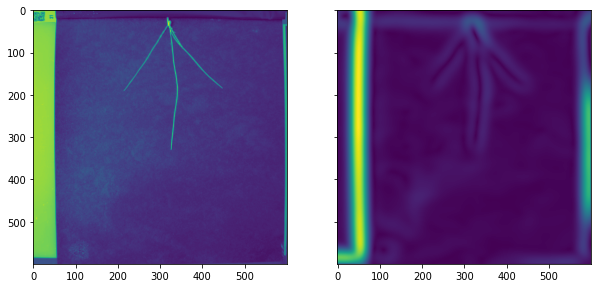

In [98]:
##visualizing w/o superposition
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax[0].imshow(raw_imgs[2,:,:])
ax[1].imshow(all_features[2,:,:,17])

# Testing

In [68]:
test_imgs = [] #testing data
testfolder = "Sample Testing/"
test_masks = [] #test labels
maskfolder ="Sample Test Mask/"

In [69]:
#down sampling images
size_x = 600
size_y = 600

In [70]:
prefix = '/content/drive/MyDrive/'
test_paths = glob.glob(prefix + testfolder +"*.*")
test_paths.sort()
myrange = np.arange(len(test_paths))

In [71]:
for i in myrange:
      ##Load raw
      basename = os.path.basename(test_paths[i])[:-3]+"png"
      #print(raw_paths[i])
      test_img = cv2.imread(test_paths[i])
      test_img = test_img[:,:,2] 
      test_img = cv2.resize(test_img, (size_x, size_y))
      ##Load mask
      filename_mask = prefix + maskfolder + basename
      #print(filename_mask)
      mask = cv2.imread(filename_mask, cv2.IMREAD_UNCHANGED)
      mask = cv2.resize(mask, (size_x, size_y), interpolation= cv2.INTER_NEAREST)
      #Only append if both read successfully
      if (True):
        test_imgs.append(test_img)
        test_masks.append(mask)
test_imgs = np.array(test_imgs)
test_masks = np.array(test_masks)
test_masks = (test_masks/255) + 1 

In [25]:
all_features_test = []

for img in test_imgs:
    features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges = True, texture=True, 
                        sigma_min=sigma_min, sigma_max=sigma_max, multichannel = True)
    features_test = features_func(img)
    all_features_test.append(features_test)
    

all_features_test = np.array(all_features_test)

In [99]:
#train and test classifiers
#clf = MLPClassifier(random_state=1, activation = 'relu', solver = 'adam', alpha = 0.0004, batch_size=200, max_iter=100) #MLP classifier
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(train_masks, all_features, clf) 
result = future.predict_segmenter(all_features_test, clf)

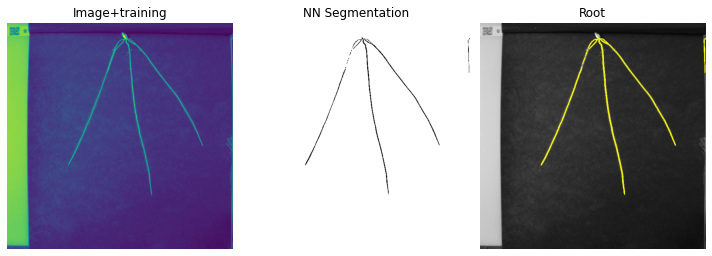

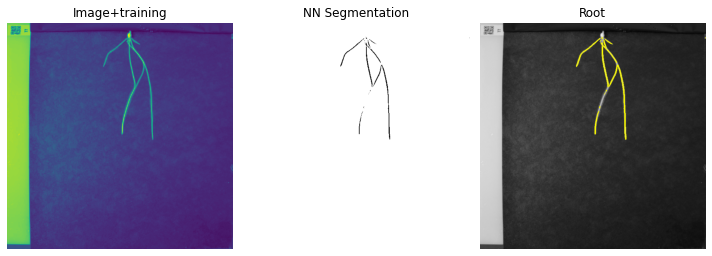

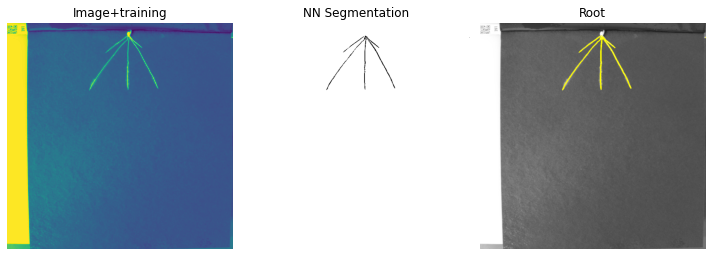

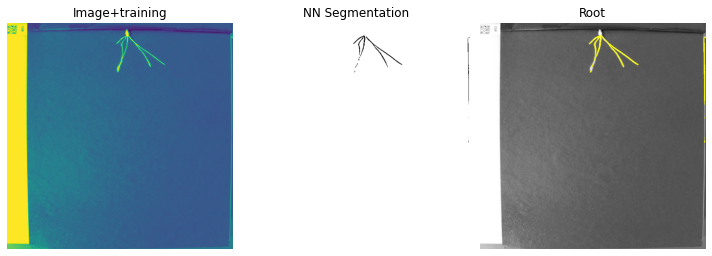

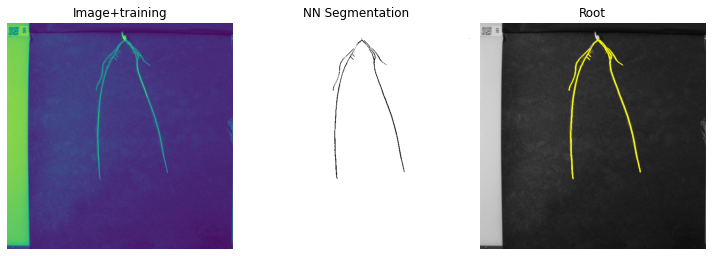

In [27]:
# Visualization of results for mlp
for (test,res) in zip(test_imgs, result):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 10))
    ax[0].imshow(test)
    #ax[0].contour(res)
    ax[0].set_title('Image+training')
    ax[0].set_axis_off()
    ax[1].imshow(res == 1,cmap='gray') #label=1 is the first class selected from crop
    ax[1].set_title('NN Segmentation')
    ax[1].set_axis_off()
    ax[2].imshow(segmentation.mark_boundaries(test, res, mode='thick'))
    ax[2].set_title('Root')
    ax[2].set_axis_off()
    fig.tight_layout()

In [30]:
## Random Forest
dice_coef(test_masks, result)

0.6577327450019066

In [100]:
##MLP
dice_coef(test_masks, result)

0.6349363197189284

# Dice Coefficient (evaluation metric)

In [28]:
import scipy.sparse
from scipy.spatial import distance

def dice_coef(test_masks, result, smooth=1):
  result = result - 1
  test_masks = test_masks - 1

  true_f = test_masks.flatten().astype(dtype=bool)
  pred_f = result.flatten().astype(dtype=bool)
 
  dice = distance.dice(pred_f, true_f)
  dice = 1 - dice
  return dice